In [1]:
from pathlib import Path
import itertools
from matplotlib import pyplot as plt
import pandas as pd
import re
from nimstim import create_csv
import numpy as np
from protosc.feature_matrix import FeatureMatrix
from protosc.filter_model import filter_model

In [2]:
# Set path to folder with faces: stim_data_dir
stim_data_dir = Path("..", "data", "Nimstim faces")

In [3]:
# Create overview of all images with their corresponding sex, emotion and mouth positioning
overview = create_csv(stim_data_dir)
overview = overview.iloc[:50]

In [4]:
from protosc.preprocessing import GreyScale, ViolaJones, CutCircle
from protosc.pipe_complex import PipeComplex
from protosc.feature_extraction import FourierFeatures
from protosc.io import ReadImage
grayscale = True

In [5]:
# Define pipeline
pipe1 = ReadImage()*ViolaJones(20)*CutCircle()*FourierFeatures()
pipe2 = ReadImage()*GreyScale()*ViolaJones(20)*CutCircle()*FourierFeatures()

pipe_complex = pipe1 + pipe2

In [6]:
def execute_pipeline(overview, sex=False, emotion=False, mouth=False):
    """ Put specified files through the pipeline"""
       
    if sex:
        overview = overview[overview['sex'] == sex]
    if emotion:
        overview = overview[overview['emotion'] == emotion]
    if mouth:
        overview = overview[overview['mouth'] == mouth]
    
    files = list(overview['file'])
    
    images = pipe_complex.execute(files)
    
    return images

In [7]:
def select_y(df, **kwargs):
    selected = np.ones(len(df), dtype=int)
    for col, val in kwargs.items():
        selected *= (df[col].values == val).astype(int)
    return selected

In [8]:
files = overview['file'].values
y = select_y(overview, mouth="open")
feature_res = pipe_complex.execute(files)

In [9]:
X = FeatureMatrix.from_pipe_data(feature_res)
X[:, 1:3].shape

(50, 6)

In [10]:
filter_res = filter_model(X, y)

In [11]:
from protosc.feature_extraction import transform_matrix
def plot_fourier(shape, i_feature):
    _, inv_matrix = transform_matrix(shape, n_spatial=7)
    feature_vec = np.zeros(56).reshape(-1, 1)
    feature_vec[i_feature] = 1
    print(inv_matrix.shape, feature_vec.shape)
    img = inv_matrix.dot(feature_vec).reshape(shape)
    plt.imshow(img)
    plt.show()

(160000, 56) (56, 1)


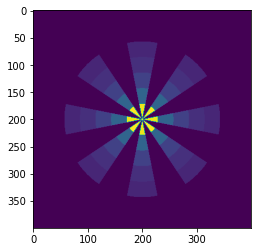

In [12]:
plot_fourier((400,400), 2*np.arange(20))